In [1]:
# Import and preprocess data
import pandas as pd
from linearmodels import PooledOLS
import statsmodels.api as sm
import numpy as np

In [2]:
evictions = pd.read_csv('evictions_ACS_ALL_10_19.csv')
#dates = evictions.index.get_level_values('date').to_list()
# dataset[‘year’] = pd.Categorical(years)

In [3]:
from pandas.tseries.offsets import Week

#evictions['week_dt'] = pd.to_datetime(evictions['date']) - pd.to_timedelta(7, unit='d')
#evictions['week_dt'] = evictions['week_dt'].where(evictions['week_dt'].dt.weekday == 0, evictions['week_dt'] - Week(weekday=0))
#evictions_week_ts = evictions.groupby(['week_dt', 'GEOID']).size().sort_values(ascending=False)

In [8]:
#evictions_week_ts = evictions_week_ts.sort_values("week_dt")

week_dt     GEOID      
2017-10-30  48113018136    2
2017-05-29  48113007819    2
            48113007826    2
            48113007825    2
            48113007823    2
dtype: int64

In [4]:
%%capture
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

all_tracts = evictions.GEOID.unique()

evictions_by_tract = []

for tract in all_tracts:
    evictions_by_tract.append(evictions[evictions.GEOID == tract].copy())

    
for tract_df in evictions_by_tract:
    fit1 = SimpleExpSmoothing(tract_df['count'], initialization_method="estimated").fit(smoothing_level=0.1)
    tract_df['smoothed'] = fit1.fittedvalues
    


In [5]:
lengths = []

for tract_df in evictions_by_tract:
    lengths.append(len(tract_df))
    
print(np.min(lengths))
print(np.max(lengths))

522
522


In [6]:
evictions_by_tract[0].tail()

,Unnamed: 0,GEOID,count,year,week,week_dt,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,...,SE_A11003_004,SE_A11003_005,SE_A11003_006,SE_A11003_007,SE_A11003_008,SE_A11003_009,SE_A11003_010,SE_A11003_011,SE_A11003_012,smoothed
455994,717079,48113000100,0.0,2019,48,2019-12-01,14000US48113000100,Census Tract 1,"Census Tract 1, Dallas County, Texas",tx,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116080
456876,718466,48113000100,0.0,2019,49,2019-12-08,14000US48113000100,Census Tract 1,"Census Tract 1, Dallas County, Texas",tx,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104472
457758,719853,48113000100,0.0,2019,50,2019-12-15,14000US48113000100,Census Tract 1,"Census Tract 1, Dallas County, Texas",tx,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094025
458640,721240,48113000100,0.0,2019,51,2019-12-22,14000US48113000100,Census Tract 1,"Census Tract 1, Dallas County, Texas",tx,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084623
459522,722627,48113000100,0.0,2019,52,2019-12-29,14000US48113000100,Census Tract 1,"Census Tract 1, Dallas County, Texas",tx,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076160


In [7]:
all_tracts_multi = pd.concat(evictions_by_tract)
all_tracts_multi = all_tracts_multi.set_index(['week_dt', 'GEOID'])

In [8]:
len(all_tracts_multi[all_tracts_multi['count'] == 0]) #lots of zeros

282018

In [9]:
# Perform PooledOLS
exog = sm.tools.tools.add_constant(all_tracts_multi['SE_A03001_003'])
endog = all_tracts_multi['smoothed']
mod = PooledOLS(endog, exog)

pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/results.py:544: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  out_df: DataFrame = concat(out, 1)


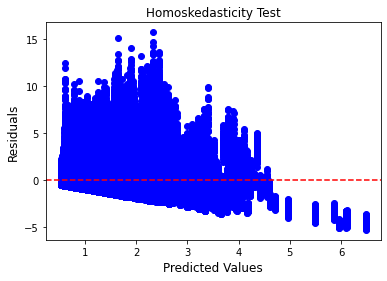

In [10]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 12)
ax.set_ylabel('Residuals', fontsize = 12)
ax.set_title('Homoskedasticity Test', fontsize = 12)
plt.show()

In [11]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([all_tracts_multi, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(all_tracts_multi['SE_A03001_003']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 26978.03966290709, 'LM p-val': 0.0, 'F-Stat': 14328.533100765333, 'F p-val': 0.0}
{'LM-Stat': 26245.623783210354, 'LM p-val': 0.0, 'F-Stat': 27832.09617267386, 'F p-val': 0.0}


/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

0.034053773625384275


In [13]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
exog = sm.tools.tools.add_constant(all_tracts_multi['SE_A03001_003'])
endog = all_tracts_multi['smoothed']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit(cov_type='clustered', cluster_entity=True) 
#print results
print(re_res)
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:               smoothed   R-squared:                        0.2147
Estimator:              RandomEffects   R-squared (Between):             -0.1172
No. Observations:              460404   R-squared (Within):               0.2150
Date:                Wed, Nov 10 2021   R-squared (Overall):              0.2110
Time:                        20:46:48   Log-likelihood                -7.414e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.258e+05
Entities:                         522   P-value                           0.0000
Avg Obs:                       882.00   Distribution:                F(1,460402)
Min Obs:                       882.00                                           
Max Obs:                       882.00   F-statistic (robust):          1.258e+05
                            

In [160]:

# make our formula:

formula = 'smoothed ~ SE_A03001_003 + SE_A06001_005 + SE_A08002B_003 + SE_A10039B_009 + SE_B18002_003 + SE_B18002_002 + SE_A10011_003'


# Perform PooledOLS
mod2 = PooledOLS.from_formula(formula, all_tracts_multi)

pooledOLS_res2 = mod2.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS2 = pooledOLS_res2.predict().fitted_values
residuals_pooled_OLS2 = pooledOLS_res2.resids

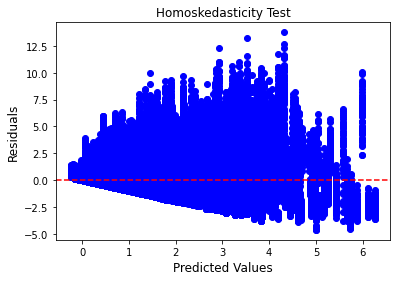

In [161]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS2, residuals_pooled_OLS2, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 12)
ax.set_ylabel('Residuals', fontsize = 12)
ax.set_title('Homoskedasticity Test', fontsize = 12)
plt.show()

In [162]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset2 = pd.concat([all_tracts_multi, residuals_pooled_OLS2], axis=1)
pooled_OLS_dataset2 = pooled_OLS_dataset2.drop(['year'], axis = 1).fillna(0)

# white_test_results = het_white(pooledOLS_res2.resids, pooledOLS_res2.model.exog)
# labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
# print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset2['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 20148.36779910611, 'LM p-val': 0.0, 'F-Stat': 21070.369469370347, 'F p-val': 0.0}


In [163]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset2['residual']) 
print(durbin_watson_test_results)

0.04865240890177004


In [34]:
# random effects model

'''


acs.demo.lm <- lm(cleaned_data$eviction_rate ~
                   as.numeric(cleaned_data$tract_hisp) + 
                   as.numeric( cleaned_data$SE_A13002_003 ) + #census tract black pct
                   as.numeric( cleaned_data$SE_A10010_003 ) + 
                   as.numeric( cleaned_data$SE_A01002A_003 ) +
                   as.numeric( cleaned_data$rent30_49pct) +
                   as.numeric( cleaned_data$pct_income_rent) + 
                   as.numeric( cleaned_data$under_povertyX2) + 
                   as.numeric( cleaned_data$rent50pct) +
                   as.numeric( cleaned_data$income_20_34k_30pct_to_housing) +
                   as.numeric( cleaned_data$no_earnings) + 
                   as.numeric( cleaned_data$SE_A10004B_012) + 
                   as.numeric( cleaned_data$SE_A10005B_002) +
                   as.numeric(cleaned_data$SE_A14028_001) + 
                   as.numeric(cleaned_data$SE_A10039B_005)

'''



formula = 'count ~ SE_A10028_006 + SE_A10005B_002 + SE_B18002_003 + SE_A13002_003 + SE_B13004_002 + SE_A03001_003 + SE_A06001_005 + SE_A08002B_003 + SE_A10039B_009 + SE_B18002_003 + SE_B18002_002 + SE_A14028_001 + SE_A10011_003 + SE_A10039B_005'

model2_re = PanelOLS.from_formula(formula, data=all_tracts_multi) 
re_res2 = model2_re.fit(cov_type='clustered', cluster_entity=True) 
#print results
print(re_res2)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  count   R-squared:                        0.2924
Estimator:                   PanelOLS   R-squared (Between):              0.8123
No. Observations:              460404   R-squared (Within):               0.1653
Date:                Wed, Nov 10 2021   R-squared (Overall):              0.2924
Time:                        21:31:35   Log-likelihood                -1.026e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.464e+04
Entities:                         522   P-value                           0.0000
Avg Obs:                       882.00   Distribution:               F(13,460391)
Min Obs:                       882.00                                           
Max Obs:                       882.00   F-statistic (robust):             381.84
                            

In [35]:
#fixed effects entity_effects = True
model2_fe = PanelOLS.from_formula(formula + " + EntityEffects", data=all_tracts_multi) 
fe_res = model2_fe.fit() 
#print results
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  count   R-squared:                        0.1661
Estimator:                   PanelOLS   R-squared (Between):              0.7109
No. Observations:              460404   R-squared (Within):               0.1661
Date:                Wed, Nov 10 2021   R-squared (Overall):              0.2731
Time:                        21:31:42   Log-likelihood                -1.014e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7043.5
Entities:                         522   P-value                           0.0000
Avg Obs:                       882.00   Distribution:               F(13,459869)
Min Obs:                       882.00                                           
Max Obs:                       882.00   F-statistic (robust):             7043.5
                            

In [36]:
#fixed effects entity_effects = True
model2_te = PanelOLS.from_formula(formula + " + EntityEffects + TimeEffects", data=all_tracts_multi) 
te_res = model2_te.fit() 
#print results
print(te_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  count   R-squared:                        0.0016
Estimator:                   PanelOLS   R-squared (Between):              0.1043
No. Observations:              460404   R-squared (Within):               0.0340
Date:                Wed, Nov 10 2021   R-squared (Overall):              0.0478
Time:                        21:34:57   Log-likelihood                -9.855e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      57.191
Entities:                         522   P-value                           0.0000
Avg Obs:                       882.00   Distribution:               F(13,458988)
Min Obs:                       882.00                                           
Max Obs:                       882.00   F-statistic (robust):             57.191
                            

In [37]:
from linearmodels import BetweenOLS, FirstDifferenceOLS, PooledOLS

mod_btwn = BetweenOLS.from_formula(formula, data=all_tracts_multi)
print(mod_btwn.fit())

                         BetweenOLS Estimation Summary                          
Dep. Variable:                  count   R-squared:                        0.8209
Estimator:                 BetweenOLS   R-squared (Between):              0.8209
No. Observations:                 522   R-squared (Within):              -254.87
Date:                Wed, Nov 10 2021   R-squared (Overall):             -204.65
Time:                        21:46:55   Log-likelihood                   -380.24
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      179.49
Entities:                         522   P-value                           0.0000
Avg Obs:                       882.00   Distribution:                  F(13,509)
Min Obs:                       882.00                                           
Max Obs:                       882.00   F-statistic (robust):             303.25
                            

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/results.py:85: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


In [ ]:
#mod_fd = FirstDifferenceOLS.from_formula(formula + " + EntityEffects", data=all_tracts_multi)
#print(mod_fd.fit())